# Regresión lineal: predecir los gastos médicos de pacientes
---

Para este ejercicio utilizaremos los datos presentados en [este](https://www.kaggle.com/mirichoi0218/insurance) dataset de Kaggle en el cual se presentan datos de seguros médicos.


## Descarga e instalación de librerías

Lo primero que se hará es descargar la librería **[regressors](https://pypi.org/project/regressors/)** que ayudará a hacer un análisis más profundo sobre la regresión lineal.

In [1]:
!pip install --upgrade pip setuptools==57.5.0
!pip install regressors

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 22.0 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 75.2.0
    Uninstalling setuptools-75.2.0:
      Successfully uninstalled setuptools-75.2.0
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
arviz 0.21.0 requires setuptools>=60.0.0, but you have setuptools 57.5.0 which is incompatible.
pytensor 2.30.2 requires setuptools>=59.0.0, but you have setuptools 57.5.0 which is incompatible.


  Preparing metadata (setup.py) ... done
  Created wheel for regressors: filename=regressors-0.0.3-py2.py3-none-any.whl size=12398 sha256=0cdd085baee92b332ece0bf35ae249ac9459b89e654bc29cb9ac8c186b814a0a
  Stored in directory: /root/.cache/pip/wheels/79/3d/27/e8e542814a63e39bd87a335aca693a993bcf262a3476af9991
Successfully built regressors
^C


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'whitegrid', context='notebook')

## Descargando los datos
Descarguemos los datos y veamos cómo se ven.

In [19]:
df = pd.read_csv('/content/insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Analizando los datos
Se observará cómo se distribuyen los datos de la variable a predecir.

(1338, 7)


<Axes: >

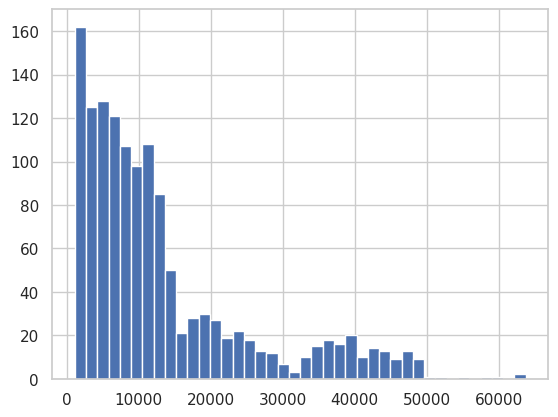

In [4]:
print(df.shape)
df.charges.hist(bins = 40)

Algo que analizar, según este gráfico, es entender qué está pasando con los datos arriba de los 50,000. Parece haber muy pocos datos de este lado.

In [20]:
df[df.charges>50000]
df = df[df.charges < 50000]

En este caso, al ser pocos datos (6 de 1338), eliminaremos estos datos atípicos. A modo didáctico producen más ruido en la predicción que se está intentando hacer en este ejercicio.

Sin embargo es importante aclarar que **NO SE DEBEN ELIMINAR** datos atípicos sin antes conocer a alguien que conozca o sea experto en los datos para que pueda guiarnos mejor sobre ellos.

In [6]:
df.describe()

,age,bmi,children,charges
count,1331.000000,1331.000000,1331.00000,1331.000000
mean,39.185575,30.633017,1.09692,13036.775677
std,14.058021,6.088782,1.20603,11699.360324
min,18.000000,15.960000,0.00000,1121.873900
25%,26.000000,26.220000,0.00000,4719.630300
50%,39.000000,30.305000,1.00000,9301.893550
75%,51.000000,34.600000,2.00000,16359.170275
max,64.000000,53.130000,5.00000,49577.662400


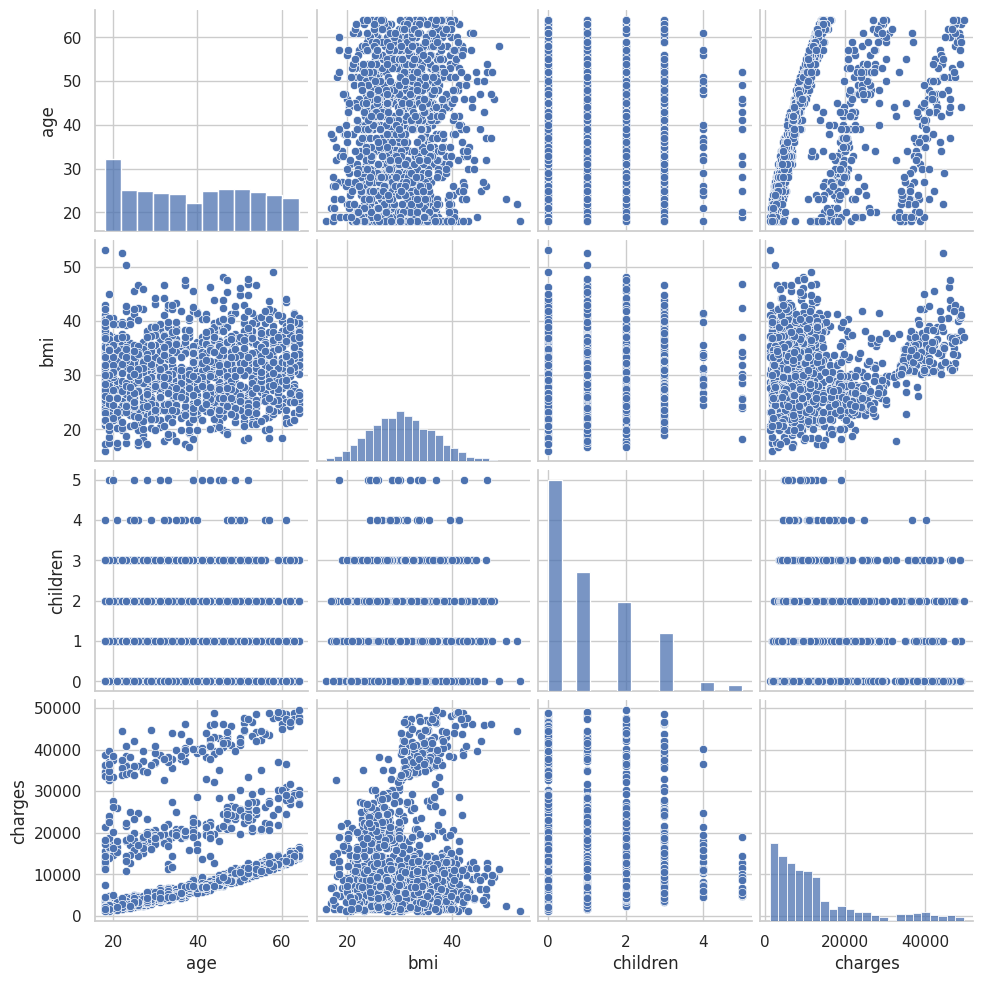

In [7]:
cols = ['age','bmi', 'children', 'charges']
sns.pairplot(df[cols], height=2.5)
plt.show()

## Viendo correlaciones
Ahora entendamos nuestros datos, viendo cómo se distribuyen y correlacionan.

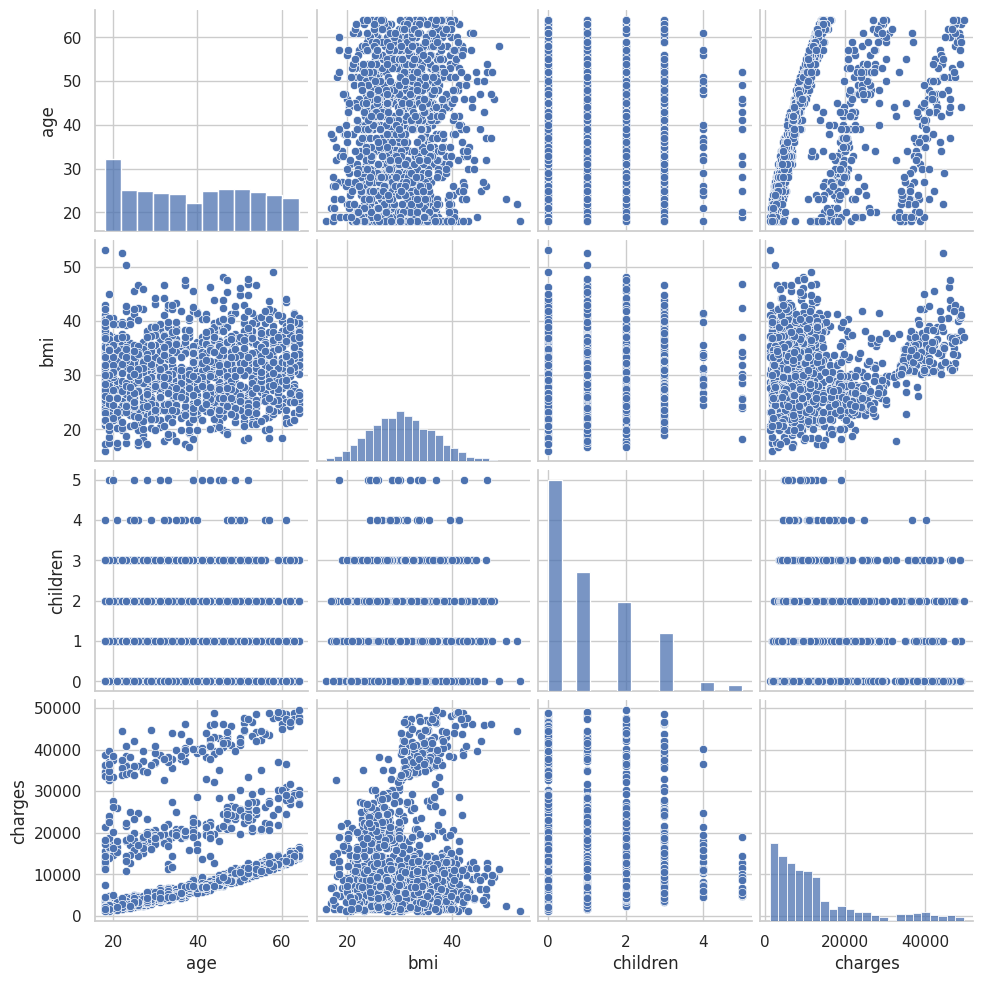

In [8]:
sns.pairplot(df, height=2.5)
plt.show()

Puntos interesantes a ver:

- Hay 3 grupos de personas diferentes que se clasifican en edad / cargos, esto puede ser un punto a analizar después.

En general los valores se distribuyen de manera esperada. Con valores extremos en el caso de los cargos, sin embargo esto es de esperarse pues los cargos en los hospitales pueden variar mucho por quedarse un día más en el hospital o incluso por procedimientos extras.

- Parece que los datos están limpios, la variable de índice de masa corporal se distribuye de manera normal o gausiana, lo cual sería esperado en un índice de este tipo.

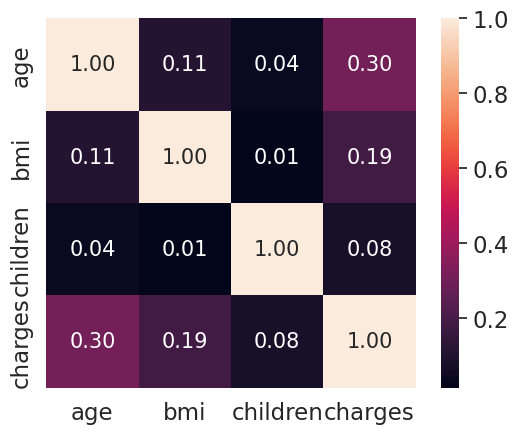

In [9]:
import numpy as np
cm =  np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 15},
                 yticklabels=cols,
                 xticklabels=cols)

## Utilizando las demás variables
Las demás variables son variables categoricas, sexo, fumador, región. Para poder utilizarlas utilizaremos la función get_dummies de pandas.

Ahora la verás en acción

In [21]:
df = pd.get_dummies(df, columns=['sex', 'smoker', 'region'], drop_first=True)
df.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,False,True,False,False,True
1,18,33.770,1,1725.55230,True,False,False,True,False
2,28,33.000,3,4449.46200,True,False,False,True,False
3,33,22.705,0,21984.47061,True,False,True,False,False
4,32,28.880,0,3866.85520,True,False,True,False,False


## Creando modelos
Primero se usará un modelo con todas las variables.

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [27]:
X_cols = list(set(df.columns) - set(['charges']))
Y_cols = ['charges']

X = df[X_cols].values
Y = df[Y_cols].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y)
sc_x  = StandardScaler().fit(X)
sc_y = StandardScaler().fit(Y)
X_train = sc_x.transform(X_train)
X_test = sc_x.transform(X_test)
Y_train = sc_y.transform(Y_train)
Y_test = sc_y.transform(Y_test)

model = LinearRegression()
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)

In [28]:
Y_pred.shape

(333, 1)

## Funciones de métricas
El siguiente punto es calcular las métricas del modelo.

In [34]:
import sklearn.metrics as metrics
mse = metrics.mean_squared_error(Y_test, Y_pred)
r2 = metrics.r2_score(Y_test, Y_pred)
print("r2:", round(r2,4))
print("mse:", round(mse,4))

r2: 0.7573
mse: 0.2324


El siguiente código muestra un resumen general de los resultados.

In [35]:
from regressors import stats
model.intercept_ = model.intercept_[0]
model.coef_ = model.coef_.reshape(-1)

In [38]:
Y_test = Y_test.reshape(-1)

print("==========Summary==========")
stats.summary(model, X_test, Y_test, X_cols)

==========Summary==========
Residuals:
    Min      1Q  Median     3Q    Max
-2.0823 -0.0886  0.1274 0.2746 0.9344


Coefficients:
                  Estimate  Std. Error  t value   p value
_intercept        0.011144    0.026602   0.4189  0.675553
region_northwest -0.016723    0.031202  -0.5360  0.592344
region_southwest -0.032480    0.031638  -1.0266  0.305355
smoker_yes        0.792227    0.026898  29.4536  0.000000
sex_male          0.000967    0.026693   0.0362  0.971112
age               0.300833    0.026732  11.2536  0.000000
region_southeast -0.025903    0.032073  -0.8076  0.419887
children          0.055628    0.026208   2.1226  0.034531
bmi               0.168113    0.026283   6.3963  0.000000
---
R-squared:  0.75733,    Adjusted R-squared:  0.75133
F-statistic: 126.39 on 8 features


Finalmente tenemos la función que calcula los residuales. Es importante notar que es una simple resta entre los valores reales y los predichos.

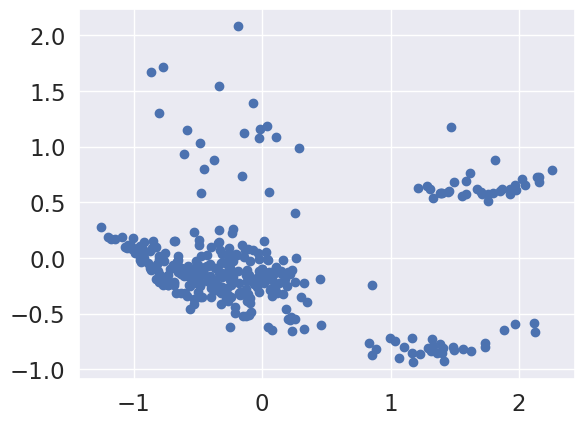

In [41]:
residuals = np.subtract(Y_test, Y_pred.reshape(-1))
plt.scatter(Y_pred, residuals)
plt.show()

## Segundo modelo
Estos resultados de arriba son buenos, pero se pueden mejorar. Intentaremos hacer algunas transformaciones sobre las variables que pueden ser de utilidad.

In [42]:
df_second = df.copy()
df_second['age2'] = df_second.age**2
df_second['sobrepeso'] = (df_second.bmi >= 30).astype(int)
df_second['sobrepeso*fumador'] = df_second.sobrepeso * df_second.smoker_yes
df_second.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,age2,sobrepeso,sobrepeso*fumador
0,19,27.900,0,16884.92400,False,True,False,False,True,361,0,0
1,18,33.770,1,1725.55230,True,False,False,True,False,324,1,0
2,28,33.000,3,4449.46200,True,False,False,True,False,784,1,0
3,33,22.705,0,21984.47061,True,False,True,False,False,1089,0,0
4,32,28.880,0,3866.85520,True,False,True,False,False,1024,0,0


Analizando el segundo modelo

In [43]:
X_cols = list(set(df_second.columns) - set(['charges']))
Y_cols = ['charges']

X = df_second[X_cols].values
Y = df_second[Y_cols].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y)
sc_x  = StandardScaler().fit(X)
sc_y = StandardScaler().fit(Y)
X_train = sc_x.transform(X_train)
X_test = sc_x.transform(X_test)
Y_train = sc_y.transform(Y_train)
Y_test = sc_y.transform(Y_test)

model = LinearRegression()
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)

In [44]:
mse = metrics.mean_squared_error(Y_test, Y_pred)
r2 = metrics.r2_score(Y_test, Y_pred)
print("r2:", round(r2,4))
print("mse:", round(mse,4))

r2: 0.8573
mse: 0.1199


In [45]:
model.intercept_ = model.intercept_[0]
model.coef_ = model.coef_.reshape(-1)

In [46]:
Y_test = Y_test.reshape(-1)

print("==========Summary==========")
stats.summary(model, X_test, Y_test, X_cols)

==========Summary==========
Residuals:
    Min     1Q  Median     3Q    Max
-2.0512 0.0643  0.1223 0.1612 0.3519


Coefficients:
                   Estimate  Std. Error  t value   p value
_intercept         0.009206    0.019269   0.4778  0.633137
region_northwest  -0.007499    0.022145  -0.3386  0.735096
region_southwest  -0.044341    0.022689  -1.9543  0.051502
smoker_yes         0.461412    0.022614  20.4035  0.000000
sex_male          -0.020118    0.019071  -1.0549  0.292231
age               -0.073551    0.103115  -0.7133  0.476168
region_southeast  -0.031218    0.022645  -1.3786  0.168944
children           0.072811    0.018068   4.0299  0.000069
sobrepeso*fumador  0.487895    0.027573  17.6943  0.000000
age2               0.402263    0.102499   3.9246  0.000106
sobrepeso         -0.045258    0.029878  -1.5148  0.130787
bmi                0.076756    0.027982   2.7430  0.006418
---
R-squared:  0.85731,    Adjusted R-squared:  0.85242
F-statistic: 175.33 on 11 features


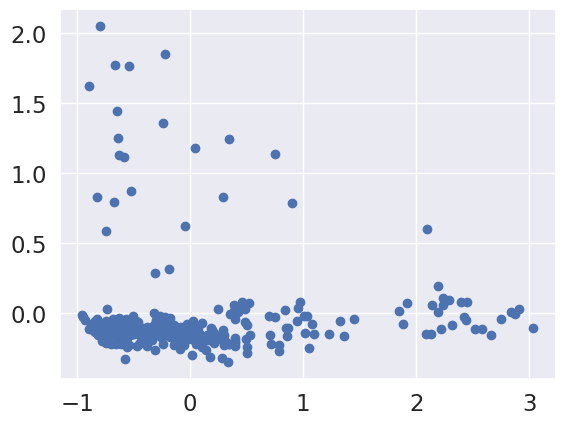

In [47]:
residuals = np.subtract(Y_test, Y_pred.reshape(-1))
plt.scatter(Y_pred, residuals)
plt.show()

Vamos a seleccionar sólo las variables cuyo p value sea menor a 0.05

In [57]:
X_cols = ['region_southwest','smoker_yes','children','sobrepeso*fumador','age2']
Y_cols = ['charges']

X = df_second[X_cols].values
Y = df_second[Y_cols].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y)
sc_x  = StandardScaler().fit(X)
sc_y = StandardScaler().fit(Y)
X_train = sc_x.transform(X_train)
X_test = sc_x.transform(X_test)
Y_train = sc_y.transform(Y_train)
Y_test = sc_y.transform(Y_test)

model = LinearRegression()
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)

In [58]:
mse = metrics.mean_squared_error(Y_test, Y_pred)
r2 = metrics.r2_score(Y_test, Y_pred)
print("r2:", round(r2,4))
print("mse:", round(mse,4))

r2: 0.8194
mse: 0.175


In [59]:
model.intercept_ = model.intercept_[0]
model.coef_ = model.coef_.reshape(-1)

In [60]:
Y_test = Y_test.reshape(-1)

print("==========Summary==========")
stats.summary(model, X_test, Y_test, X_cols)

==========Summary==========
Residuals:
    Min     1Q  Median     3Q   Max
-2.0164 0.0368  0.0931 0.1351 0.377


Coefficients:
                   Estimate  Std. Error  t value   p value
_intercept        -0.009088    0.022982  -0.3955  0.692762
region_southwest  -0.038697    0.022411  -1.7267  0.085158
smoker_yes         0.463712    0.030342  15.2828  0.000000
children           0.071833    0.022998   3.1234  0.001945
sobrepeso*fumador  0.493959    0.030235  16.3372  0.000000
age2               0.312643    0.023636  13.2275  0.000000
---
R-squared:  0.81935,    Adjusted R-squared:  0.81659
F-statistic: 296.63 on 5 features


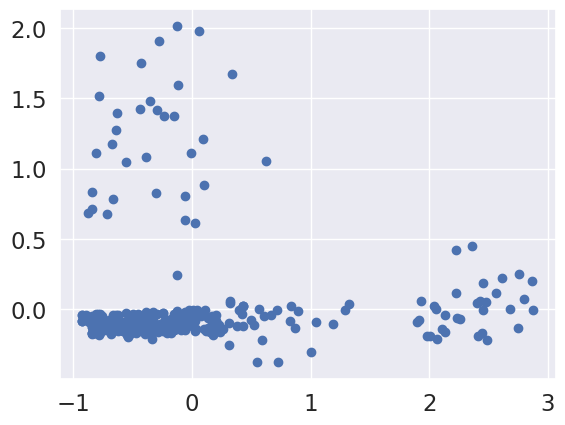

In [61]:
residuals = np.subtract(Y_test, Y_pred.reshape(-1))
plt.scatter(Y_pred, residuals)
plt.show()

In [67]:
X_cols = ['smoker_yes','children','sobrepeso*fumador','age2']
Y_cols = ['charges']

X = df_second[X_cols].values
Y = df_second[Y_cols].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y)
sc_x  = StandardScaler().fit(X)
sc_y = StandardScaler().fit(Y)
X_train = sc_x.transform(X_train)
X_test = sc_x.transform(X_test)
Y_train = sc_y.transform(Y_train)
Y_test = sc_y.transform(Y_test)

model = LinearRegression(fit_intercept=False)
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)

In [68]:
mse = metrics.mean_squared_error(Y_test, Y_pred)
r2 = metrics.r2_score(Y_test, Y_pred)
print("r2:", round(r2,4))
print("mse:", round(mse,4))

r2: 0.8786
mse: 0.1213


In [70]:
model.coef_ = model.coef_.reshape(-1)

In [71]:
Y_test = Y_test.reshape(-1)

print("==========Summary==========")
stats.summary(model, X_test, Y_test, X_cols)

==========Summary==========
Residuals:
    Min    1Q  Median     3Q    Max
-2.0435 0.069  0.1137 0.1444 0.2512


Coefficients:
                   Estimate  Std. Error  t value   p value
_intercept         0.000000    0.019165   0.0000  1.000000
smoker_yes         0.440415    0.024988  17.6253  0.000000
children           0.079501    0.017950   4.4289  0.000013
sobrepeso*fumador  0.499124    0.024934  20.0176  0.000000
age2               0.330069    0.018752  17.6015  0.000000
---
R-squared:  0.87865,    Adjusted R-squared:  0.87717
F-statistic: 593.70 on 4 features


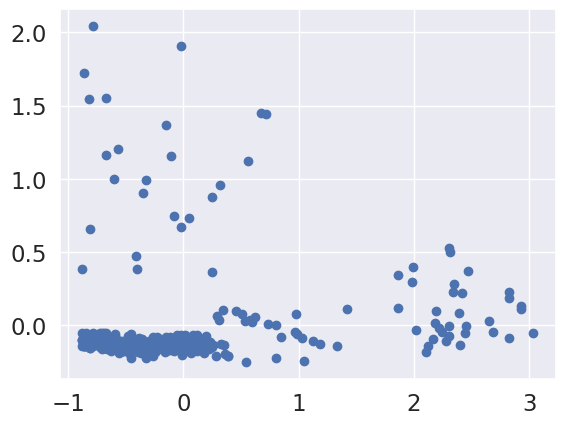

In [72]:
residuals = np.subtract(Y_test, Y_pred.reshape(-1))
plt.scatter(Y_pred, residuals)
plt.show()